In [1]:
%load_ext autoreload
%autoreload 2
from pixell import enmap,enplot
import numpy as np
import symlens
import soapack.interfaces as sints

pixell : https://github.com/simonsobs/pixell/

soapack : https://github.com/simonsobs/soapack

symlens : https://github.com/simonsobs/symlens

# pixell + soapack + symlens demo

## Loading an ACT map with soapack

In [11]:
mask = sints.get_act_mr3_crosslinked_mask('deep6',version="180323")
dm = sints.ACTc7v5(region=mask)
imap = dm.get_coadd("S1","D6","PA1",ncomp=1)

## Plotting an ACT map with pixell

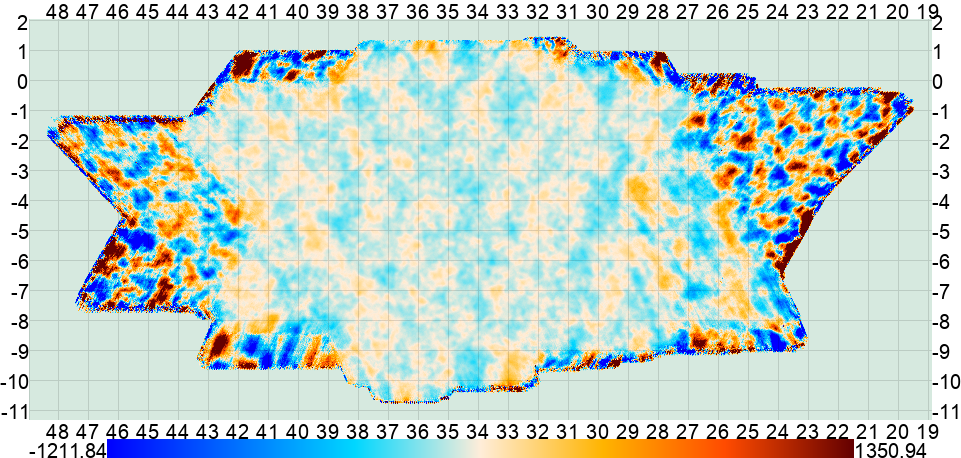

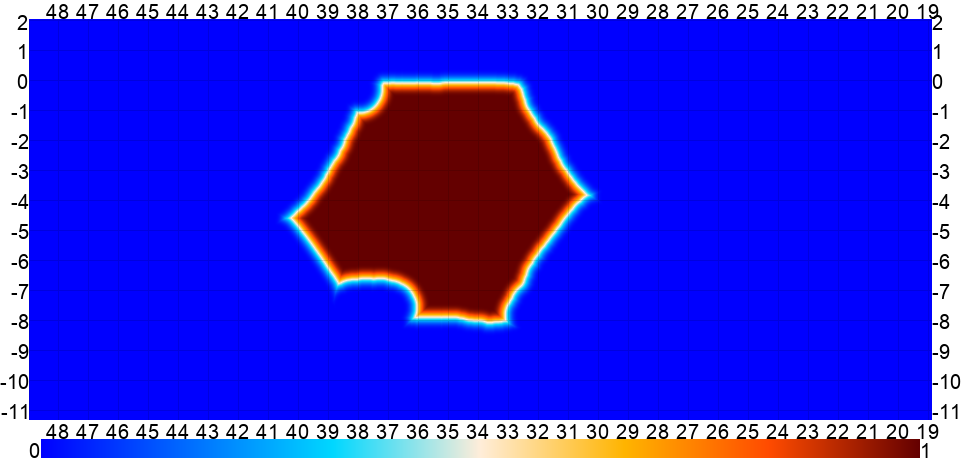

In [12]:
enplot.show(enplot.plot(imap,downgrade=4,colorbar=True))
enplot.show(enplot.plot(mask,downgrade=4,colorbar=True))

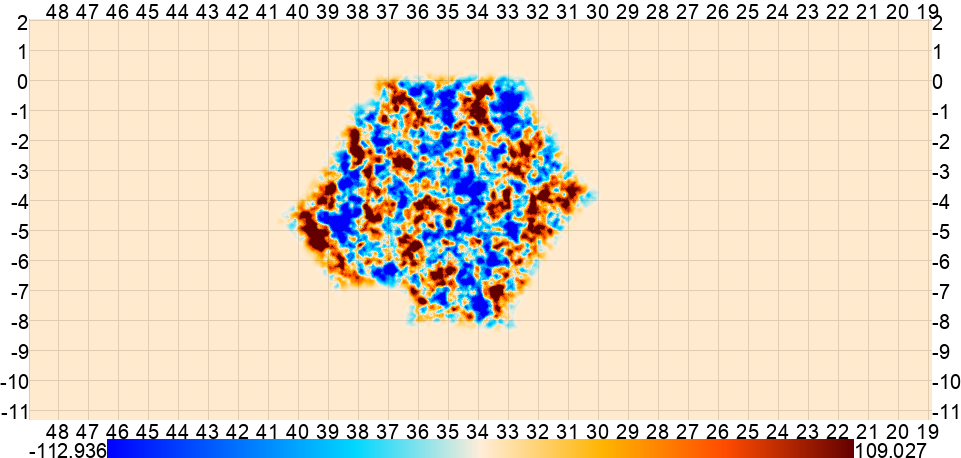

In [13]:
tmap = imap*mask
enplot.show(enplot.plot(tmap,downgrade=4,colorbar=True))

## Map manipulation with pixell + lensing reconstruction with symlens

In [14]:
# Get geometry and fourier info
shape,wcs = tmap.shape,tmap.wcs
modlmap = enmap.modlmap(shape,wcs)

# Build a beam
fwhm = 1.4
kbeam = np.exp(-(np.deg2rad(fwhm / 60.)**2.)*(modlmap**2.) / (16.*np.log(2.)))

# Get theory spectrum
ells,cltt = np.loadtxt("cltt.txt",unpack=True)

# Build interpolated 2D Fourier CMB theory
ucltt2d = np.interp(modlmap,ells,cltt)
# And total noise power for filters
tcltt2d = ucltt2d + np.nan_to_num((10.*np.pi/180./60.)**2./kbeam**2.)

# Build a Fourier space mask
kmask = modlmap*0+1
kmask[modlmap<500] = 0
kmask[modlmap>3000] = 0

# Get beam deconvolved fourier map
kmap = np.nan_to_num(enmap.fft(tmap,normalize="phys")/kbeam)

# Build symlens dictionary
feed_dict = {
    'uC_T_T' : ucltt2d,
    'tC_T_T' : tcltt2d,
    'X' : kmap,
    'Y' : kmap,
}

# Ask for reconstruction in Fourier space
krecon = symlens.reconstruct(shape, wcs, feed_dict, estimator="hu_ok", XY="TT", xmask=kmask, ymask=kmask, kmask=kmask,pixel_units=False)

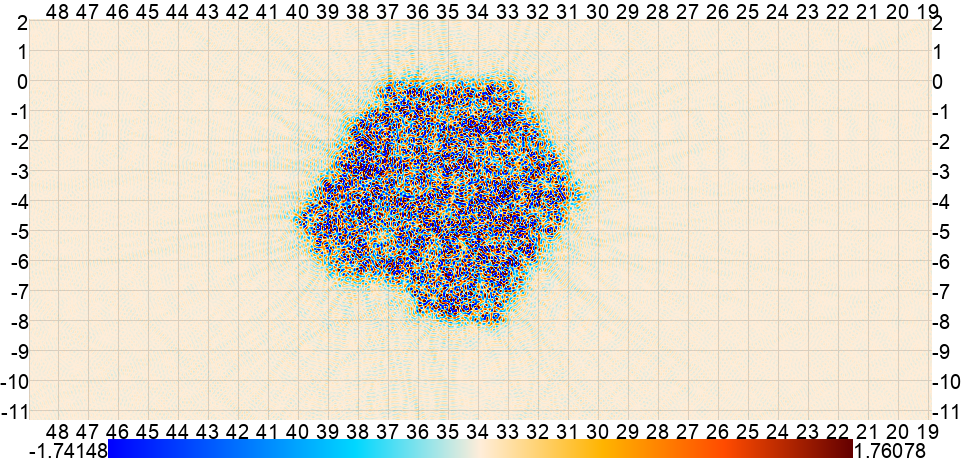

In [15]:
# Transform to real space and plot
kappa = enmap.ifft(krecon,normalize="phys").real
enplot.show(enplot.plot(enmap.downgrade(kappa,4),colorbar=True))